## gaussian map 패치 합치기

In [13]:
import torch
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import torch.nn.functional as F
from patchify import patchify


model = torch.load('/data/ephemeral/home/level2-cv-semanticsegmentation-cv-10/develop/yumin/trainer/save_dir/_26_res50_BC_fp16_ignore_RLROP_skfd_hardaugV2_8_4_2048_patchy.pt')
SAVE_CSV_NAME = '26_res50_BC_fp16_ignore_RLROP_skfd_hardaugV2_8_4_2048_patchy_gaussian.csv'
IMAGE_ROOT = "../../data/test/DCM"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]


pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}


# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

def reconstruct_image(patches):
    full_image = torch.zeros((len(CLASSES), 1024, 1024), dtype=torch.float32)
    step = 256
    idx = 0
    for row in range(3):
        for col in range(3):
            start_row, start_col = row * step, col * step
            full_image[:, start_row:start_row+step, start_col:start_col+step] = patches[idx]
            idx += 1
    return full_image

def gaussian_map(inputs, size):
    img_size = size

    # 가우시안 분포의 표준편차
    sigma = img_size / 3  # 표준편차를 조절하여 가중치 감소 속도 조정

    x = np.linspace(-img_size / 2, img_size / 2, img_size)
    y = np.linspace(-img_size / 2, img_size / 2, img_size)
    x, y = np.meshgrid(x, y)
    d = np.sqrt(x**2 + y**2)
    gaussian_mapping = np.exp(-(d**2 / (2.0 * sigma**2)))
    weighted_map = inputs*gaussian_mapping
    # print(type(weighted_map))
    return weighted_map

class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
        self.patch_storage = {}
    
    def __len__(self):
        return len(self.filenames) * 9
    
    def __getitem__(self, item):
        image_index = item // 9
        patch_index = item % 9

        image_name = self.filenames[image_index]
        image_path = os.path.join(IMAGE_ROOT, image_name)  # 'IMAGE_ROOT' should be defined
        image = cv2.imread(image_path)
        
        image_patches = patchify(image, (1024, 1024, 3), step=512)
        patch_row, patch_col = divmod(patch_index, 3)
        image_patch = image_patches[patch_row, patch_col, 0, :, :, :]

        if self.transforms is not None:
            transformed = self.transforms(image=image_patch)
            image_patch = transformed["image"]

        image_patch = image_patch / 255.
        image_patch = image_patch.transpose(2, 0, 1)  
        
        image_patch = torch.from_numpy(image_patch).float()

        return image_patch, image_name


def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    patch_outputs = []
    
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            image_index = step // 9
            patch_index = step % 9
            window = 1024
            step = 512

            if patch_index == 0:
                back = np.zeros((29, 2048,2048), dtype=np.float64)
                
            images = images.cuda()    
            outputs = model(images)['out'] # resnet 사용할 경우
            # outputs = model(images) # Unet 사용할 경우

            outputs = F.interpolate(outputs, size=(1024, 1024), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            # outputs = (outputs > thr).detach().cpu().numpy()
            outputs = (outputs).detach().cpu().numpy()
            
            row = patch_index // 3
            col = patch_index % 3

            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    back[c, row*step:row*step+window, col*step:col*step+window] += gaussian_map(segm, 1024)          

            if patch_index == 8:
                back = np.where(back > thr, True, False)
                for c, segm in enumerate(back):
                    # print('c :',c)
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                
    return rles, filename_and_class

tf = A.Resize(1024, 1024)
tf_1 = A.Compose([A.Resize(512,512),
                  A.CLAHE()])

test_dataset = XRayInferenceDataset(transforms=tf)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=8,
    drop_last=False
)

rles, filename_and_class = test(model, test_loader)

  0%|          | 0/1296 [00:00<?, ?it/s]

KeyboardInterrupt: 

finger-1_ID040/image1661319116107.png


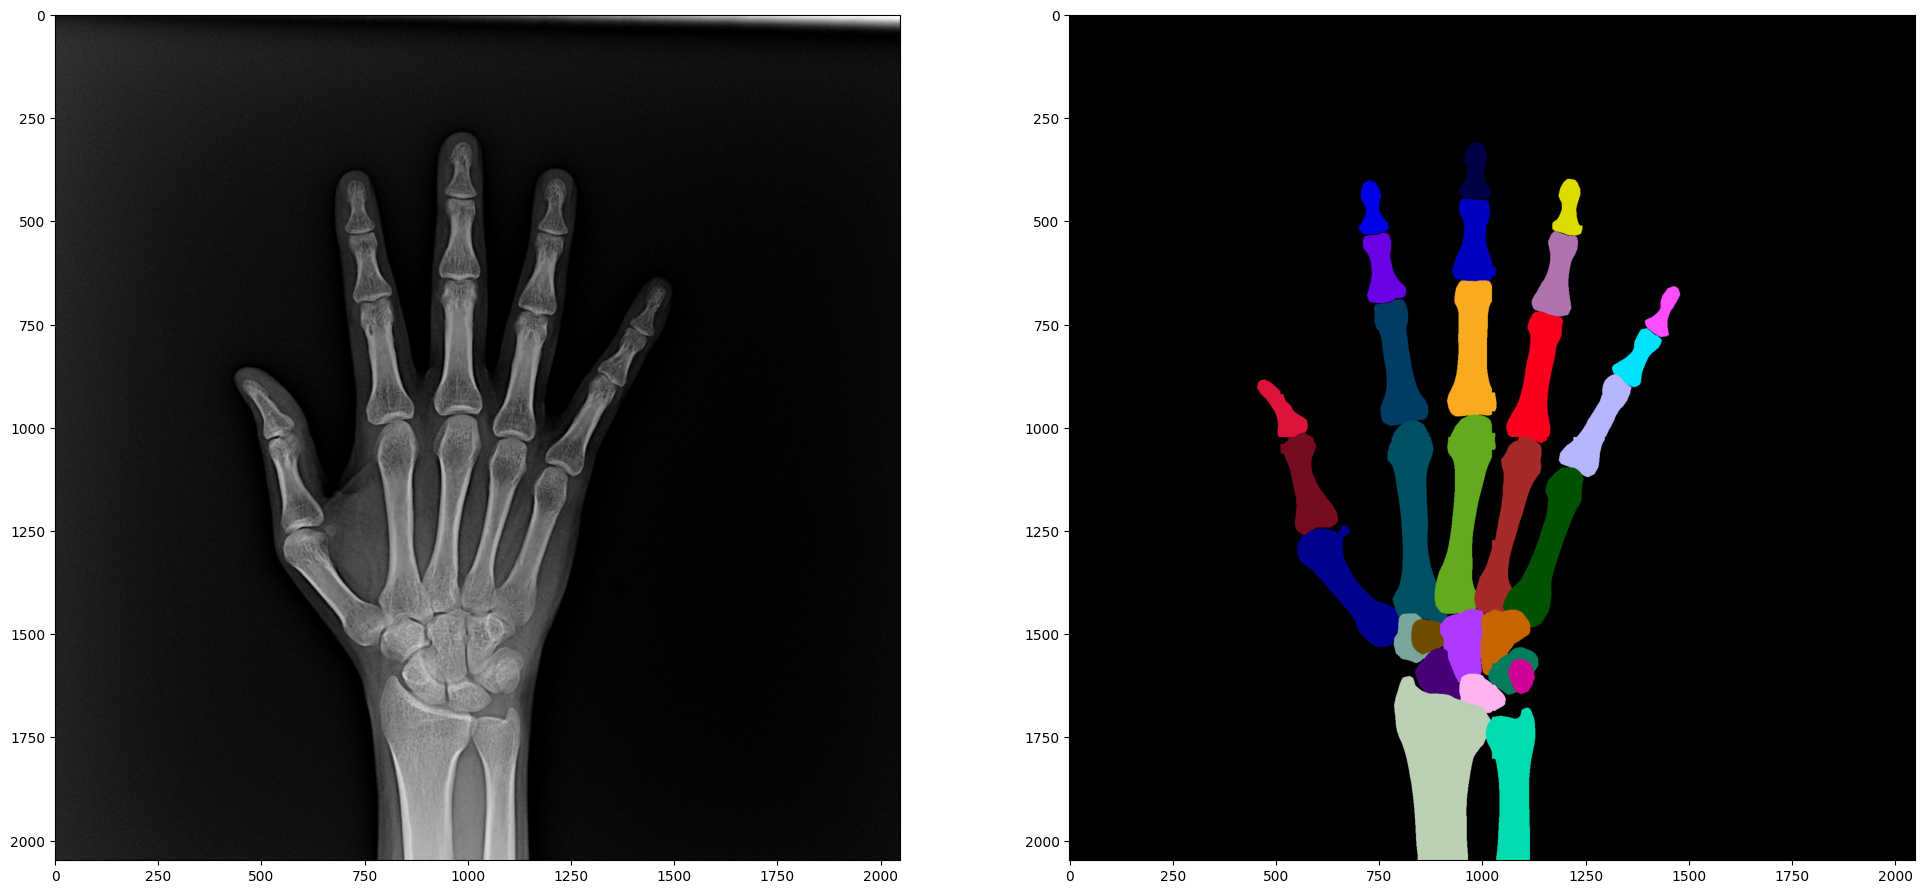

In [3]:
print(filename_and_class[0])
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))
preds = []

for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

In [5]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

image_name = [os.path.basename(f) for f in filename]

df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

df.head(30)

df.to_csv(SAVE_CSV_NAME, index=False)

## 9개 이미지 comcat

In [4]:
import torch
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import torch.nn.functional as F
from patchify import patchify


model = torch.load('/data/ephemeral/home/level2-cv-semanticsegmentation-cv-10/develop/yumin/trainer/save_dir/_26_res50_BC_fp16_ignore_RLROP_skfd_hardaugV2_8_4_2048_patchy.pt')
SAVE_CSV_NAME = '26_res50_BC_fp16_ignore_RLROP_skfd_hardaugV2_8_4_2048_patchy.csv'
IMAGE_ROOT = "../../data/test/DCM"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]


pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}
def gaussian_map(inputs, size):
    img_size = size

    # 가우시안 분포의 표준편차
    sigma = img_size / 3  # 표준편차를 조절하여 가중치 감소 속도 조정

    x = np.linspace(-img_size / 2, img_size / 2, img_size)
    y = np.linspace(-img_size / 2, img_size / 2, img_size)
    x, y = np.meshgrid(x, y)
    d = np.sqrt(x**2 + y**2)
    map = np.exp(-(d**2 / (2.0 * sigma**2)))
    return map*inputs

# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

def reconstruct_image(patches):
    full_image = torch.zeros((len(CLASSES), 1024, 1024), dtype=torch.float32)
    step = 256
    idx = 0
    for row in range(3):
        for col in range(3):
            start_row, start_col = row * step, col * step
            full_image[:, start_row:start_row+step, start_col:start_col+step] = patches[idx]
            idx += 1
    return full_image

class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
        self.patch_storage = {}
    
    def __len__(self):
        return len(self.filenames) * 9
    
    def __getitem__(self, item):
        image_index = item // 9
        patch_index = item % 9

        image_name = self.filenames[image_index]
        image_path = os.path.join(IMAGE_ROOT, image_name)  # 'IMAGE_ROOT' should be defined
        image = cv2.imread(image_path)
        
        image_patches = patchify(image, (1024, 1024, 3), step=512)
        patch_row, patch_col = divmod(patch_index, 2)
        image_patch = image_patches[patch_row, patch_col, 0, :, :, :]

        if self.transforms is not None:
            transformed = self.transforms(image=image_patch)
            image_patch = transformed["image"]

        image_patch = image_patch / 255.
        image_patch = image_patch.transpose(2, 0, 1)  
        
        image_patch = torch.from_numpy(image_patch).float()

        return image_patch, image_name


def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    patch_outputs = []
    
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            image_index = step // 9
            patch_index = step % 9
            window = 1024
            step = 512

            if patch_index == 0:
                back = np.zeros((29, 2048,2048), dtype=np.uint8)
                
            images = images.cuda()    
            # outputs = model(images)['out'] # resnet 사용할 경우
            outputs = model(images) # Unet 사용할 경우

            outputs = F.interpolate(outputs, size=(1024, 1024), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            # outputs = (outputs).detach().cpu().numpy()
            
            row = patch_index // 3
            col = patch_index % 3

            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    back[c, row*step:row*step+window, col*step:col*step+window] = segm
            back = np.where(back > thr, 1, 0)

            if patch_index == 8:
                for c, segm in enumerate(back):
                    # print('c :',c)
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                
    return rles, filename_and_class

tf = A.Resize(512, 512)
tf_1 = A.Compose([A.Resize(512,512),
                  A.CLAHE()])

test_dataset = XRayInferenceDataset(transforms=tf)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=1,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

rles, filename_and_class = test(model, test_loader)

  0%|          | 0/1296 [00:00<?, ?it/s]

finger-1_ID040/image1661319116107.png


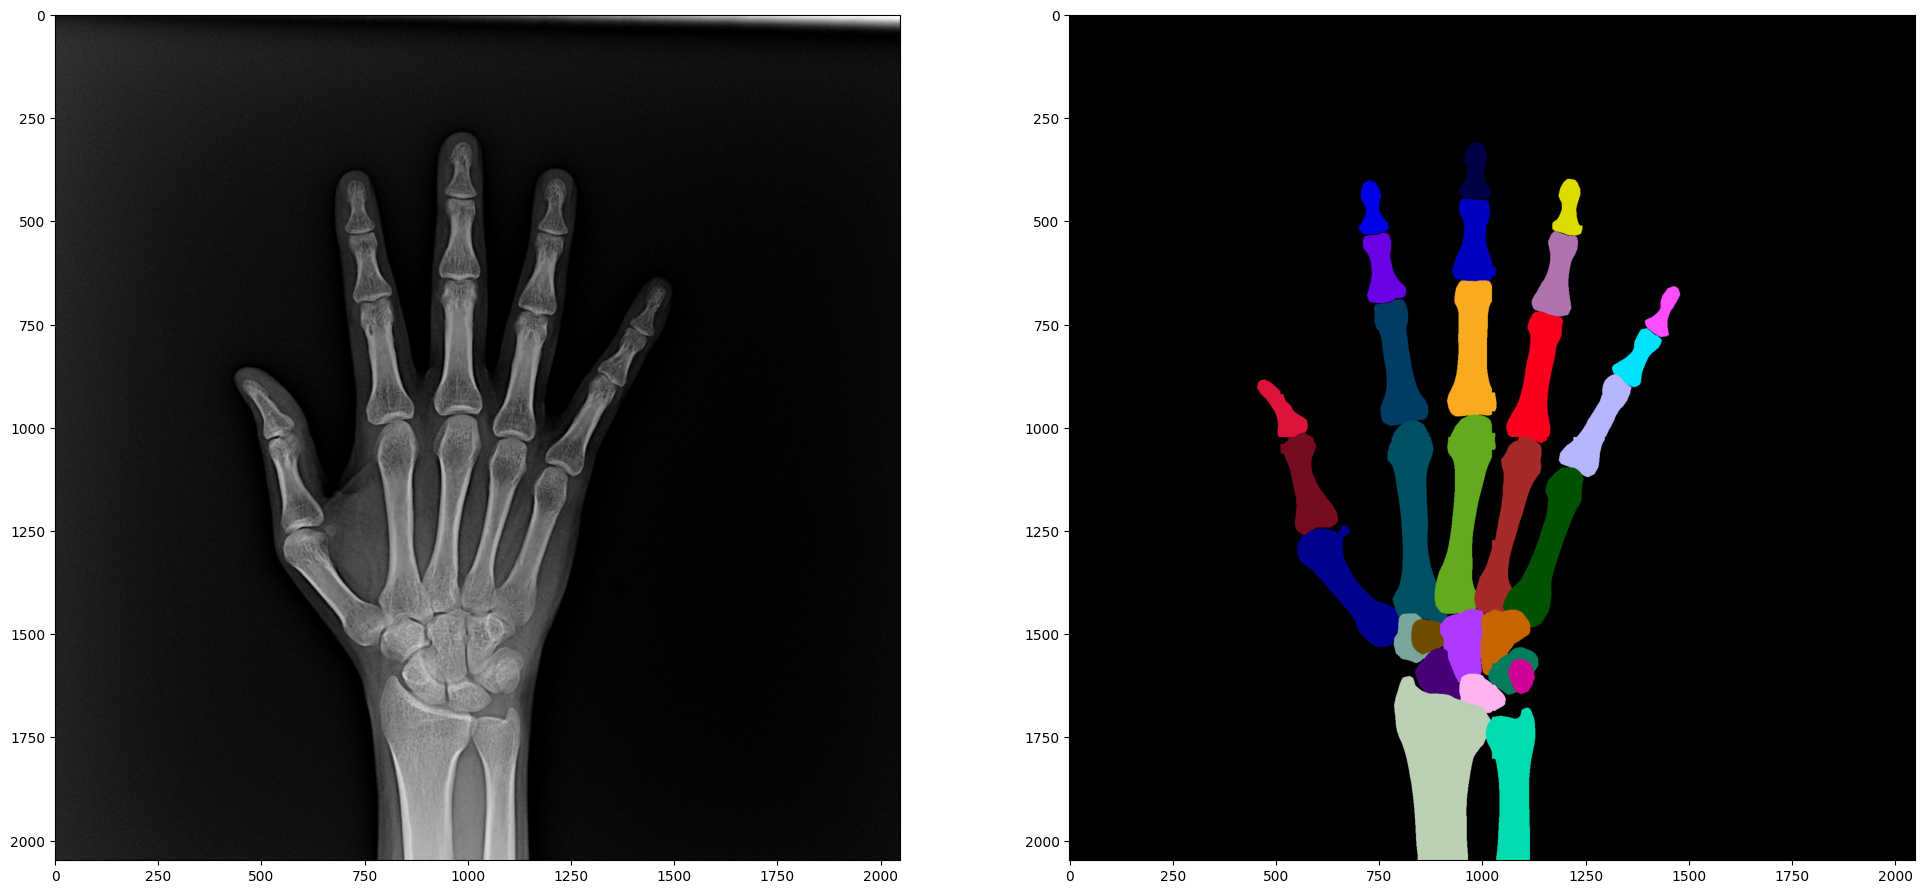

In [ ]:
print(filename_and_class[0])
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))
preds = []

for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

In [ ]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

image_name = [os.path.basename(f) for f in filename]

df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

df.head(30)

df.to_csv(SAVE_CSV_NAME, index=False)

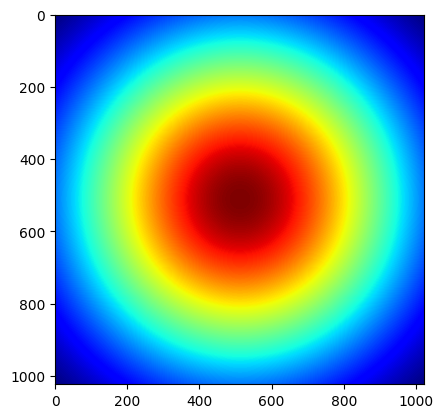

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# def gaussian_map(inputs, size):/
img_size = 1024

# 가우시안 분포의 표준편차
sigma = img_size / 3  # 표준편차를 조절하여 가중치 감소 속도 조정

x = np.linspace(-img_size / 2, img_size / 2, img_size)
y = np.linspace(-img_size / 2, img_size / 2, img_size)
x, y = np.meshgrid(x, y)
d = np.sqrt(x**2 + y**2)
map = np.exp(-(d**2 / (2.0 * sigma**2)))

plt.imshow(map, cmap='jet')
plt.show()